В этом мини-проекте мы посчитаем несколько продуктовых метрик и посмотрим, какие распределения могут встретиться на практике.  
### Задача
1. Загрузите [данные](https://disk.yandex.ru/d/Kl4mPINblwnJCA), проверьте число наблюдений и столбцов, типы данных, наличие пропущенных значений, какие уникальные значения встречаются.
2. Постройте график распределения числа показов (`Impressions`) для каждой рекламы, прологарифмировав значения.
3. Создайте новую колонку c `CTR`. Посмотрите на описательные статистики и распределение.
4. Проанализируйте `CTR` с разбивкой по рекламной кампании.
5. Посчитайте стоимость за клик пользователя по объявлению (`CPC`). Изучите полученные значения, используя меры центральной тенденции и меры изменчивости. 
6. Визуализируйте `CPC` с разбивкой по полу пользователей, которым были показаны объявления. 
7. Посчитайте конверсию из клика в покупку.

### Описание данных
- `ad_id` – идентификатор объявления (рекламы)  
- `xyz_campaign_id` – идентификатор рекламной кампании в базе компании X  
- `fb_campaign_id` – идентификатор кампании в Facebook  
- `age` – возрастная группа, которой показывалась реклама  
- `gender` – пол тех, кому показывалась реклама  
- `interest` – код, указывающий категорию, к которой относится интерес пользователя (соответствие число – интерес)  
- `impressions` – число показов  
- `clicks` – число кликов  
- `spent` – сумма, которую компания потратила на показ объявления   
- `total_conversion` – количество людей, которые заинтересовались продуктом после просмотра рекламы  
- `approved_conversion` – количество людей, которые купили продукт после просмотра рекламы  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import scipy.stats as ss
import requests
from urllib.parse import urlencode

In [2]:
# загружаем данные и сохраняем их в текущую папку
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/Kl4mPINblwnJCA'                       # ссылка на данные

# получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('conversion.csv', 'wb') as f:
    f.write(download_response.content)

In [3]:
# загружаем данные
conversion = pd.read_csv('conversion.csv')

In [4]:
# число наблюдений и столбцов
conversion.shape

(1143, 11)

In [5]:
# типы данных
conversion.dtypes

ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object

In [6]:
# наличие пропущенных значений
for col in conversion.columns:
    print(f'Пропущено значений в колонке {col.ljust(20)}: {conversion[col].isna().sum()}')

Пропущено значений в колонке ad_id               : 0
Пропущено значений в колонке xyz_campaign_id     : 0
Пропущено значений в колонке fb_campaign_id      : 0
Пропущено значений в колонке age                 : 0
Пропущено значений в колонке gender              : 0
Пропущено значений в колонке interest            : 0
Пропущено значений в колонке Impressions         : 0
Пропущено значений в колонке Clicks              : 0
Пропущено значений в колонке Spent               : 0
Пропущено значений в колонке Total_Conversion    : 0
Пропущено значений в колонке Approved_Conversion : 0


In [7]:
# уникальные значения
print(*conversion.age.unique(), sep=', ')
print(*conversion.gender.unique(), sep=', ')
print(*conversion.interest.unique(), sep=', ')

30-34, 35-39, 40-44, 45-49
M, F
15, 16, 20, 28, 29, 27, 31, 7, 30, 24, 21, 32, 18, 63, 65, 25, 10, 19, 26, 36, 23, 64, 22, 2, 66, 100, 101, 102, 103, 105, 107, 110, 111, 112, 113, 108, 109, 114, 104, 106


In [8]:
# количество уникальных рекламных кампаний
conversion.xyz_campaign_id.nunique()

3

In [9]:
# подготовим данные для графика распределения числа показов
impressions_df = (        
    conversion
        .groupby('fb_campaign_id', as_index = False)
        .agg({'Impressions': 'sum'})
)
impressions_df['Impressions_log'] = np.log(impressions_df.Impressions)
impressions_df.head()

,fb_campaign_id,Impressions,Impressions_log
0,103916,7350,8.902456
1,103917,17861,9.790375
2,103920,693,6.541030
3,103928,8392,9.035034
4,103929,1915,7.557473


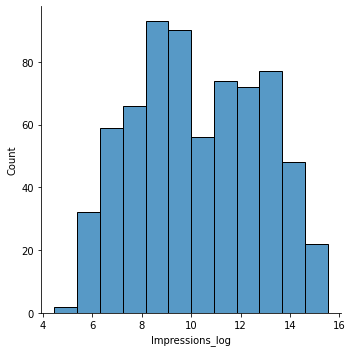

In [10]:
# график распределения числа показов (log)
sns.displot(impressions_df.Impressions_log)

Распределение бимодальное

In [11]:
# CTR (click-through rate) - т.е. отношение числа кликов к количеству показов
conversion['CTR'] = conversion.Clicks / conversion.Impressions
conversion.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.000136
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.000112
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.000000
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.000235
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.000242


In [12]:
(
    conversion
        .query('CTR == CTR.max()')
        .ad_id
)

150    738637
Name: ad_id, dtype: int64

In [13]:
print('средний CTR:              ', conversion.CTR.mean())
print('медианный CTR:            ', conversion.CTR.median())
print('мода CTR:                 ', conversion.CTR.mode()[0])
print('межквартильный размах CTR:', ss.iqr(conversion.CTR, nan_policy='omit'))

средний CTR:               0.00016419671305996467
медианный CTR:             0.00015980898126474708
мода CTR:                  0.0
межквартильный размах CTR: 0.0001334143888399813


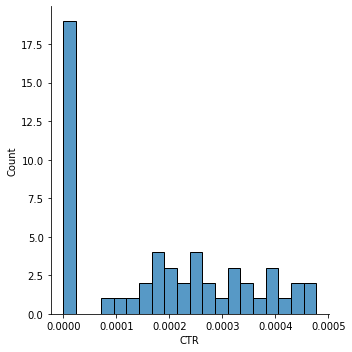

In [14]:
# Визуализация CTR с разбивкой по номеру рекламной кампании (xyz_campaign_id == "916")
sns.displot(
    conversion
        .query('xyz_campaign_id == "916"')
        .CTR
    , bins=20
)

In [15]:
# CPC (cost-per-click) – стоимость за клик пользователя по объявлению.
conversion['CPC'] = conversion.Spent / conversion.Clicks
conversion.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR,CPC
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.000136,1.43
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.000112,0.91
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.000000,NaN
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.000235,1.25
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.000242,1.29


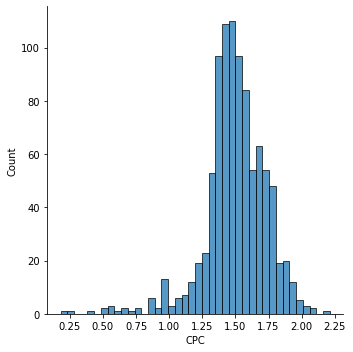

In [16]:
sns.displot(conversion.CPC.dropna())

In [17]:
# межквартильный размах CPC
ss.iqr(conversion.CPC, nan_policy='omit')

0.25436369905

In [19]:
print('средний CPC:              ', conversion.CPC.mean())
print('медианный CPC:            ', conversion.CPC.median())
print('мода CPC:                 ', conversion.CPC.mode())
print('межквартильный размах CPC:', ss.iqr(conversion.CPC, nan_policy='omit'))

средний CPC:               1.4993474467280832
медианный CPC:             1.498273039292763
мода CPC:                  0    1.38
1    1.48
dtype: float64
межквартильный размах CPC: 0.25436369905


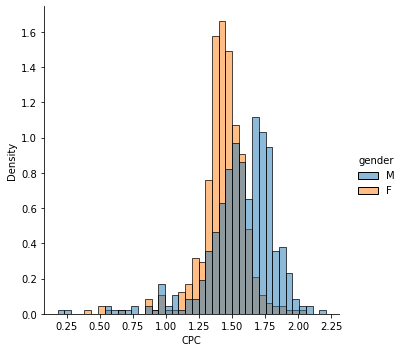

In [22]:
# Визуализируем CPC с разбивкой по полу пользователей, которым были показаны объявления. Какой график получился?
sns.displot(data=conversion.dropna(), x='CPC', hue='gender', stat="density")

In [23]:
# sns.distplot(conversion.query('gender == "M"').CPC.dropna())
# sns.distplot(conversion.query('gender == "F"').CPC.dropna())

In [24]:
# конверсия CR из клика в покупку
conversion['CR'] = conversion.Approved_Conversion / conversion.Clicks * 100
conversion.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR,CPC,CR
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.000136,1.43,100.0
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.000112,0.91,0.0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.000000,NaN,NaN
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.000235,1.25,0.0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.000242,1.29,100.0


In [25]:
# конверсия для объявления 1121814
conversion.query('ad_id == 1121814').CR.round(2)

860    3.09
Name: CR, dtype: float64